# Load basic packages/modules

In [133]:
import os
import numpy as np
import pandas as pd

import nltk
from nltk import corpus, tokenize
from nltk.corpus import stopwords

import re

from nltk.stem import PorterStemmer, WordNetLemmatizer, porter
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string

from sklearn.model_selection import train_test_split

# ML
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# DNN/MLP/ANN model

# Load Review Dataset

In [134]:
hotstar = pd.read_csv("hotstar_reviews.csv")
hotstar.head()

,ID,UserName,Created_Date,Reviews,Lower_Case_Reviews,Sentiment_Manual_BP,Sentiment_Manual,Review_Length,DataSource,Year,Month,Date,Sentiment_Polarity
0,1,NaN,08-10-2017,Hh,hh,Negative,Negative,2,Google_PlayStore,2017,8,10,Neutral
1,2,NaN,08-11-2017,No,no,Negative,Negative,2,Google_PlayStore,2017,8,11,Neutral
2,3,asadynwa,08-12-2017,@hotstar_helps during paymnt for premium subsc...,@hotstar_helps during paymnt for premium subsc...,Help,Negative,140,Twitter,2017,8,12,Negative
3,4,jineshroxx,08-11-2017,@hotstartweets I am currently on Jio network a...,@hotstartweets i am currently on jio network a...,Help,Negative,140,Twitter,2017,8,11,Positive
4,5,YaminiSachar,08-05-2017,@hotstartweets the episodes of Sarabhai vs Sar...,@hotstartweets the episodes of sarabhai vs sar...,Help,Negative,140,Twitter,2017,8,5,Neutral


In [135]:
hotstar.shape

(5053, 13)

In [136]:
hotstar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5053 entries, 0 to 5052
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   5053 non-null   int64 
 1   UserName             4331 non-null   object
 2   Created_Date         5053 non-null   object
 3   Reviews              5053 non-null   object
 4   Lower_Case_Reviews   5053 non-null   object
 5   Sentiment_Manual_BP  5053 non-null   object
 6   Sentiment_Manual     5053 non-null   object
 7   Review_Length        5053 non-null   int64 
 8   DataSource           5053 non-null   object
 9   Year                 5053 non-null   int64 
 10  Month                5053 non-null   int64 
 11  Date                 5053 non-null   int64 
 12  Sentiment_Polarity   5053 non-null   object
dtypes: int64(5), object(8)
memory usage: 513.3+ KB


In [137]:
hotstar.Sentiment_Manual.value_counts()

,count
Sentiment_Manual,
Neutral,1738
Positive,1733
Negative,1582


In [138]:
hotstar.Sentiment_Manual.value_counts()/hotstar.Sentiment_Manual.size*100

,count
Sentiment_Manual,
Neutral,34.395409
Positive,34.296458
Negative,31.308134


In [139]:
hotstar.DataSource.value_counts()/hotstar.DataSource.size*100

,count
DataSource,
Twitter,55.927172
Google_PlayStore,44.072828


In [140]:
pd.pivot_table(hotstar, index='Sentiment_Manual', columns='DataSource',
              values='ID', aggfunc='count')/hotstar.DataSource.size*100

DataSource,Google_PlayStore,Twitter
Sentiment_Manual,,
Negative,12.923016,18.385118
Neutral,5.125668,29.269741
Positive,26.024144,8.272313


In [141]:
hotstar.columns

Index(['ID', 'UserName', 'Created_Date', 'Reviews', 'Lower_Case_Reviews',
       'Sentiment_Manual_BP', 'Sentiment_Manual', 'Review_Length',
       'DataSource', 'Year', 'Month', 'Date', 'Sentiment_Polarity'],
      dtype='object')

# Data Cleaning

In [142]:
review_data = hotstar[['Lower_Case_Reviews','DataSource','Sentiment_Manual']]
review_data.head()

,Lower_Case_Reviews,DataSource,Sentiment_Manual
0,hh,Google_PlayStore,Negative
1,no,Google_PlayStore,Negative
2,@hotstar_helps during paymnt for premium subsc...,Twitter,Negative
3,@hotstartweets i am currently on jio network a...,Twitter,Negative
4,@hotstartweets the episodes of sarabhai vs sar...,Twitter,Negative


In [143]:
review_data.columns = ['Reviews','Source','Sentiment']
review_data.head()

,Reviews,Source,Sentiment
0,hh,Google_PlayStore,Negative
1,no,Google_PlayStore,Negative
2,@hotstar_helps during paymnt for premium subsc...,Twitter,Negative
3,@hotstartweets i am currently on jio network a...,Twitter,Negative
4,@hotstartweets the episodes of sarabhai vs sar...,Twitter,Negative


In [144]:
review_data.describe(include='object')

,Reviews,Source,Sentiment
count,5053,5053,5053
unique,5053,2,3
top,very very frustrating navigation this applicat...,Twitter,Neutral
freq,1,2826,1738


In [145]:
review_data.Source.value_counts()

,count
Source,
Twitter,2826
Google_PlayStore,2227


In [146]:
review_data['Source'] = review_data['Source'].astype('category')
review_data['Source'] = review_data['Source'].cat.codes
review_data['Source'].value_counts()

/tmp/ipython-input-3689932828.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data['Source'] = review_data['Source'].astype('category')
/tmp/ipython-input-3689932828.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data['Source'] = review_data['Source'].cat.codes


,count
Source,
1,2826
0,2227


In [147]:
review_data.head()

,Reviews,Source,Sentiment
0,hh,0,Negative
1,no,0,Negative
2,@hotstar_helps during paymnt for premium subsc...,1,Negative
3,@hotstartweets i am currently on jio network a...,1,Negative
4,@hotstartweets the episodes of sarabhai vs sar...,1,Negative


In [148]:
list(string.punctuation)

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~']

In [149]:
punctuation = list(string.punctuation)

stop_words = stopwords.words('english')

re_pattern = """@[a-zA-Z0-9_:]+|b['"]rt|[\d]+[a-zA-Z_+='?]+[\d]+[\d]+|[a-zA-Z_*+=]+[\d]+[a-zA-Z_*+-=]+|[\d]+"""

re_pattern = re_pattern + """|https:+[a-zA-Z0-9/._+-=]+|&amp;|rt"""

reviewText = [re.sub(pattern = re_pattern, string = text, repl="")
               for text in review_data.Reviews.map(str).values]

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-4199886841.py:5: SyntaxWarning: invalid escape sequence '\d'
  re_pattern = """@[a-zA-Z0-9_:]+|b['"]rt|[\d]+[a-zA-Z_+='?]+[\d]+[\d]+|[a-zA-Z_*+=]+[\d]+[a-zA-Z_*+-=]+|[\d]+"""


In [150]:
re_pattern

'@[a-zA-Z0-9_:]+|b[\'"]rt|[\\d]+[a-zA-Z_+=\'?]+[\\d]+[\\d]+|[a-zA-Z_*+=]+[\\d]+[a-zA-Z_*+-=]+|[\\d]+|https:+[a-zA-Z0-9/._+-=]+|&amp;|rt'

In [151]:
print(reviewText[7])

 why today s epi of #lovekahaiintezaar nt available on available now it was in d morning now showing nt available due expiry


In [152]:
# re.sub('[^a-zA-Z]',' ',Review[i])

In [153]:
# @hotstar_helps during paymnt for premium subscription the transaction failed twice but i have not
# received refund for one of the transaction

In [154]:
review_data_cleaned = []

for review in reviewText:
    stop_free = " ".join([txt for txt in review.lower().split() if txt not in stop_words])
    # stop_words - NLTK
    stop_free_1 = " ".join([txt for txt in stop_free.lower().split() if txt not in STOPWORDS])
    # STOPWORDS - WORDCLOUD
    puct_free = " ".join([txt for txt in stop_free_1.lower().split() if txt not in punctuation])
    review_data_cleaned.append(puct_free)

In [155]:
review_data_cleaned[7]

'today epi #lovekahaiintezaar nt available available morning showing nt available due expiry'

In [156]:
# remove hashtags
review_data_cleaned_final = []

for rdcf in review_data_cleaned:
    final_words = rdcf.replace("#",'')
    review_data_cleaned_final.append(final_words)


In [157]:
review_data_cleaned_final[7]

'today epi lovekahaiintezaar nt available available morning showing nt available due expiry'

In [158]:
review_data_cleaned_final[57]

'need buy rs premier league pack compulsory watch pl matches already premium pack activated'

In [159]:
len(review_data_cleaned)

5053

In [160]:
"""
corpus = []
for i in range(len(review_data_cleaned)):
    review = re.sub('[^a-zA-Z]',' ',review_data_cleaned[i])
    review = ''.join(review)
    corpus.append(review)

"""

"\ncorpus = []\nfor i in range(len(review_data_cleaned)):\n    review = re.sub('[^a-zA-Z]',' ',review_data_cleaned[i])\n    review = ''.join(review)\n    corpus.append(review)\n    \n"

In [161]:
# Lemmatization

wd = WordNetLemmatizer()

review_data_cleaned_final_output = []
for rdc in review_data_cleaned_final:
    clean_review = " ".join(wd.lemmatize(word) for word in rdc.split())
    review_data_cleaned_final_output.append(clean_review)

In [162]:
review_data_cleaned_final_output

['hh',
 '',
 'paymnt premium subscription transaction failed twice received refund one transaction',
 'currently jio network know whether able watch epl telecasted star spos select hd',
 'episode sarabhai v sarabhai season downloadable able watch offline please smthng',
 'able watch latest episode got app allow take screenshot error help resolve asap',
 'please allow rupay maestro payment gateway premium membership mean paytm work thru debit card great',
 'today epi lovekahaiintezaar nt available available morning showing nt available due expiry',
 'hotstarfraud paid subscription july havent received cashback specified hdfc card',
 'premium accnt hotstar showing tht premium member u pls chk',
 'seeing blank page term amp condition hdfc bank cashback offer hotstar premium membership please help',
 'sir please allow u download video ur app present option allow u dwnld mre video due ltd space',
 'hi pl tab spos homepage isl bundesliga search team name stream pls look',
 'unable watch star

In [163]:
review_data['clean_review'] = review_data_cleaned_final_output

/tmp/ipython-input-3331724023.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data['clean_review'] = review_data_cleaned_final_output


In [164]:
review_data.head()

,Reviews,Source,Sentiment,clean_review
0,hh,0,Negative,hh
1,no,0,Negative,
2,@hotstar_helps during paymnt for premium subsc...,1,Negative,paymnt premium subscription transaction failed...
3,@hotstartweets i am currently on jio network a...,1,Negative,currently jio network know whether able watch ...
4,@hotstartweets the episodes of sarabhai vs sar...,1,Negative,episode sarabhai v sarabhai season downloadabl...


In [165]:
# split the data into training and test

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(review_data['clean_review'],
                                                review_data['Sentiment'],test_size=0.2,
                                                   random_state=42,
                                                   stratify=review_data['Sentiment'])

In [166]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(4042,) (1011,) (4042,) (1011,)


# Feature Extraction - Bag of Words

In [167]:
# vectorize the text data using CountVectorizer

vectorizer = CountVectorizer(binary=True).fit(x_train)
x_train_vectorized = vectorizer.transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)

In [168]:
x_train

,clean_review
2669,good aap
4312,suddenly stas buffering n buffering n bufferin...
2512,watch bengaluru bull v telugu titan live star ...
2722,osam app
3254,easy use
...,...
350,app working
4952,glad waited watched latest gameofthrones episo...
958,called live feed exact second delayed transmis...
67,order id premium membership cancelled free tra...


In [169]:
x_train_vectorized

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 24736 stored elements and shape (4042, 4980)>

In [170]:
print(vectorizer.get_feature_names_out())

['aa' 'aaaaaand' 'aaaaah' ... 'zinab' 'zindabad' 'znmd']


In [171]:
pd.DataFrame(x_train_vectorized.toarray())

,0,1,2,3,4,5,6,7,8,9,...,4970,4971,4972,4973,4974,4975,4976,4977,4978,4979
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [172]:
pd.DataFrame(x_test_vectorized.toarray())

,0,1,2,3,4,5,6,7,8,9,...,4970,4971,4972,4973,4974,4975,4976,4977,4978,4979
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Model Building

## from sklearn.naive_bayes import MultinomialNB

In [173]:
naive_bayes_multi = MultinomialNB().fit(x_train_vectorized, y_train)

In [174]:
print(naive_bayes_multi.score(x_train_vectorized, y_train))
print()
print(naive_bayes_multi.score(x_test_vectorized, y_test))

0.8800098960910441

0.7141444114737884


In [175]:
naive_bayes_multi.feature_log_prob_

array([[-8.83840675, -9.53155393, -9.53155393, ..., -8.83840675,
        -8.83840675, -8.83840675],
       [-9.64432815, -8.95118097, -8.95118097, ..., -9.64432815,
        -9.64432815, -9.64432815],
       [-9.25473996, -9.25473996, -9.25473996, ..., -9.25473996,
        -9.25473996, -9.25473996]])

In [176]:
predict_train = naive_bayes_multi.predict(x_train_vectorized)
predict_test = naive_bayes_multi.predict(x_test_vectorized)

In [177]:
predict_train

array(['Positive', 'Negative', 'Neutral', ..., 'Negative', 'Negative',
       'Negative'], dtype='<U8')

In [178]:
predict_test

array(['Negative', 'Positive', 'Positive', ..., 'Neutral', 'Neutral',
       'Neutral'], dtype='<U8')

In [179]:
def get_num(data):
    data_new = pd.DataFrame(data, columns=['Sentiment'])
    data_new['y_label'] = np.where(data_new['Sentiment']=='Neutral',0,
                                  np.where(data_new['Sentiment']=='Positive',1,2))
    return data_new

In [180]:
y_train_new = get_num(y_train)
y_test_new = get_num(y_test)
predict_train_new = get_num(predict_train)
predict_test_new = get_num(predict_test)

In [181]:
predict_test_new

,Sentiment,y_label
0,Negative,2
1,Positive,1
2,Positive,1
3,Neutral,0
4,Neutral,0
...,...,...
1006,Neutral,0
1007,Positive,1
1008,Neutral,0
1009,Neutral,0


In [182]:
print(classification_report(y_train_new['y_label'],predict_train_new['y_label'] ))
print()
print(classification_report(y_test_new['y_label'],predict_test_new['y_label'] ))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1390
           1       0.90      0.91      0.91      1386
           2       0.83      0.91      0.87      1266

    accuracy                           0.88      4042
   macro avg       0.88      0.88      0.88      4042
weighted avg       0.88      0.88      0.88      4042


              precision    recall  f1-score   support

           0       0.67      0.66      0.66       348
           1       0.80      0.73      0.76       347
           2       0.68      0.76      0.72       316

    accuracy                           0.71      1011
   macro avg       0.72      0.72      0.71      1011
weighted avg       0.72      0.71      0.71      1011



In [183]:
print(accuracy_score(y_train_new['y_label'],predict_train_new['y_label'] ))
print()
print(accuracy_score(y_test_new['y_label'],predict_test_new['y_label'] ))

0.8800098960910441

0.7141444114737884


# RandomForestClassifier

In [184]:
rf_model = RandomForestClassifier().fit(x_train_vectorized, y_train)

In [185]:
print(rf_model.score(x_train_vectorized, y_train))
print()
print(rf_model.score(x_test_vectorized, y_test))

0.9903513112320633

0.6993076162215628


In [186]:
predict_train1 = rf_model.predict(x_train_vectorized)
predict_test1 = rf_model.predict(x_test_vectorized)

In [187]:
def get_num(data):
    data_new = pd.DataFrame(data, columns=['Sentiment'])
    data_new['y_label'] = np.where(data_new['Sentiment']=='Neutral',0,
                                  np.where(data_new['Sentiment']=='Positive',1,2))
    return data_new

In [188]:
y_train_new1 = get_num(y_train)
y_test_new1 = get_num(y_test)
predict_train_new1 = get_num(predict_train1)
predict_test_new1 = get_num(predict_test1)

In [189]:
print(classification_report(y_train_new1['y_label'],predict_train_new1['y_label'] ))
print()
print(classification_report(y_test_new1['y_label'],predict_test_new1['y_label'] ))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1390
           1       0.99      0.99      0.99      1386
           2       1.00      0.99      0.99      1266

    accuracy                           0.99      4042
   macro avg       0.99      0.99      0.99      4042
weighted avg       0.99      0.99      0.99      4042


              precision    recall  f1-score   support

           0       0.66      0.72      0.69       348
           1       0.74      0.75      0.75       347
           2       0.70      0.63      0.66       316

    accuracy                           0.70      1011
   macro avg       0.70      0.70      0.70      1011
weighted avg       0.70      0.70      0.70      1011



In [190]:
print(accuracy_score(y_train_new1['y_label'],predict_train_new1['y_label'] ))
print()
print(accuracy_score(y_test_new1['y_label'],predict_test_new1['y_label'] ))

0.9903513112320633

0.6993076162215628


# apply k-fold method

In [191]:
from sklearn.model_selection import cross_val_score
training_accuracy = cross_val_score(rf_model, x_train_vectorized, y_train, cv=10)
print(training_accuracy.mean())

0.7384995721794402


# XGBoostClassifier

In [192]:
def get_num(data):
    data_new = pd.DataFrame(data, columns=['Sentiment'])
    data_new['y_label'] = np.where(data_new['Sentiment']=='Neutral',0,
                                  np.where(data_new['Sentiment']=='Positive',1,2))
    return data_new

In [193]:
y_train_new2 = get_num(y_train)
y_test_new2 = get_num(y_test)

In [194]:
y_train_new2

,Sentiment,y_label
2669,Positive,1
4312,Negative,2
2512,Neutral,0
2722,Positive,1
3254,Positive,1
...,...,...
350,Negative,2
4952,Positive,1
958,Negative,2
67,Negative,2


In [195]:
xgboost = XGBClassifier().fit(x_train_vectorized, y_train_new2['y_label'])

In [196]:
print(xgboost.score(x_train_vectorized, y_train_new2['y_label']))
print()
print(xgboost.score(x_test_vectorized, y_test_new2['y_label']))

0.838941118258288

0.7181008902077152


In [197]:
from sklearn.model_selection import cross_val_score
training_accuracy = cross_val_score(xgboost, x_train_vectorized, y_train_new2['y_label'], cv=10)
print(training_accuracy.mean())

0.7377496638552744


# Feature Extraction - Term Frequency - Inverse Documents Frequency (TF-IDF)

In [198]:
# vectorize the text data using TfidfVectorizer
tf_idf = TfidfVectorizer().fit(x_train)
x_train_tf_idf = tf_idf.transform(x_train)
x_test_tf_idf = tf_idf.transform(x_test)

In [199]:
pd.DataFrame(x_test_tf_idf.toarray())

,0,1,2,3,4,5,6,7,8,9,...,4970,4971,4972,4973,4974,4975,4976,4977,4978,4979
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [200]:
x_test_tf_idf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [201]:
xgboost = XGBClassifier().fit(x_train_tf_idf, y_train_new2['y_label'])

In [202]:
print(xgboost.score(x_train_tf_idf, y_train_new2['y_label']))
print()
print(xgboost.score(x_test_tf_idf, y_test_new2['y_label']))

0.8834735279564572

0.7111770524233432


# Analysis by using WordCloud

In [203]:
review_data.head()

,Reviews,Source,Sentiment,clean_review
0,hh,0,Negative,hh
1,no,0,Negative,
2,@hotstar_helps during paymnt for premium subsc...,1,Negative,paymnt premium subscription transaction failed...
3,@hotstartweets i am currently on jio network a...,1,Negative,currently jio network know whether able watch ...
4,@hotstartweets the episodes of sarabhai vs sar...,1,Negative,episode sarabhai v sarabhai season downloadabl...


In [204]:
review_data.Sentiment.value_counts()

,count
Sentiment,
Neutral,1738
Positive,1733
Negative,1582


In [205]:
positive_review = review_data[review_data['Sentiment']=='Positive']['clean_review']
negative_review = review_data[review_data['Sentiment']=='Negative']['clean_review']
neutral_review = review_data[review_data['Sentiment']=='Neutral']['clean_review']

In [206]:
positive_review.shape, negative_review.shape, neutral_review.shape

((1733,), (1582,), (1738,))

In [213]:
import nltk
pos_data_token = [nltk.word_tokenize(rvw) for rvw in positive_review]
neg_data_token = [nltk.word_tokenize(rvw) for rvw in negative_review]
neu_data_token = [nltk.word_tokenize(rvw) for rvw in neutral_review]

In [214]:
neu_data_token

[[],
 ['speed'],
 ['sssss'],
 ['sunni'],
 ['app'],
 ['thank'],
 ['ufgjj'],
 ['vipul'],
 ['fghk'],
 ['god'],
 ['att', 'aa'],
 ['better'],
 ['crazzy'],
 ['hank'],
 ['ok'],
 ['kiduve'],
 ['krunal'],
 ['raju'],
 ['mash'],
 ['mmmmmm'],
 ['ok'],
 ['peasad'],
 ['rakesh'],
 ['rayudu'],
 ['salmon'],
 ['serial'],
 ['shahal'],
 ['thanks'],
 [],
 ['average'],
 ['cleay'],
 ['cricket'],
 ['forever'],
 ['hotstar'],
 ['ok'],
 ['ok'],
 ['kp', 'joel'],
 ['live', 'tv'],
 ['love'],
 ['machand'],
 ['must'],
 ['nit', 'bad'],
 ['word'],
 ['bad'],
 ['yet'],
 ['nothing'],
 ['ooooooo'],
 ['praveen'],
 ['quality'],
 ['sahi', 'hi'],
 ['sandeep'],
 ['sirraaa'],
 ['sonysab'],
 ['subhash'],
 ['tv', 'show'],
 ['vismaya'],
 ['well'],
 [],
 ['chuyyapa'],
 ['download'],
 ['hawa', 'xaw'],
 ['itds', 'okk'],
 ['word'],
 ['nrrrrrrr'],
 ['pudikale'],
 ['raj', 'bhai'],
 ['semmaiya'],
 ['shailesh'],
 ['thankyou'],
 ['abhi', 'abhi'],
 ['buffering'],
 ['chhota', 'tv'],
 ['hostar'],
 ['hq', 'video'],
 ['okay'],
 ['likhith'],
 ['k

In [215]:
wordcloud_pos = WordCloud(background_color='blue', max_words=200, max_font_size=40,
                         scale=3, random_state=10).generate(str(pos_data_token))

wordcloud_neg = WordCloud(background_color='white', max_words=200, max_font_size=40,
                         scale=3, random_state=10).generate(str(neg_data_token))

wordcloud_neu = WordCloud(background_color='black', max_words=200, max_font_size=40,
                         scale=3, random_state=10).generate(str(neu_data_token))

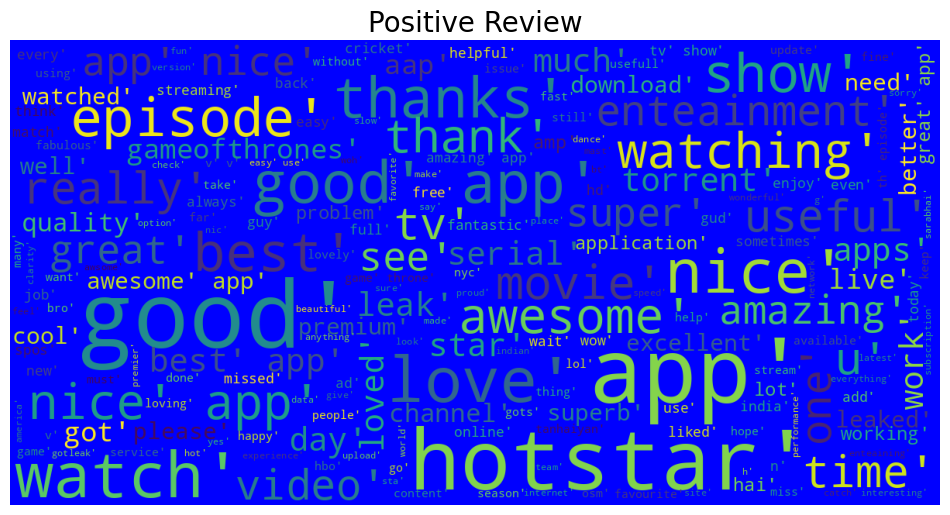

In [216]:
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(12,12))
plt.axis('off')
plt.imshow(wordcloud_pos)
plt.title("Positive Review", size=20)
plt.show()

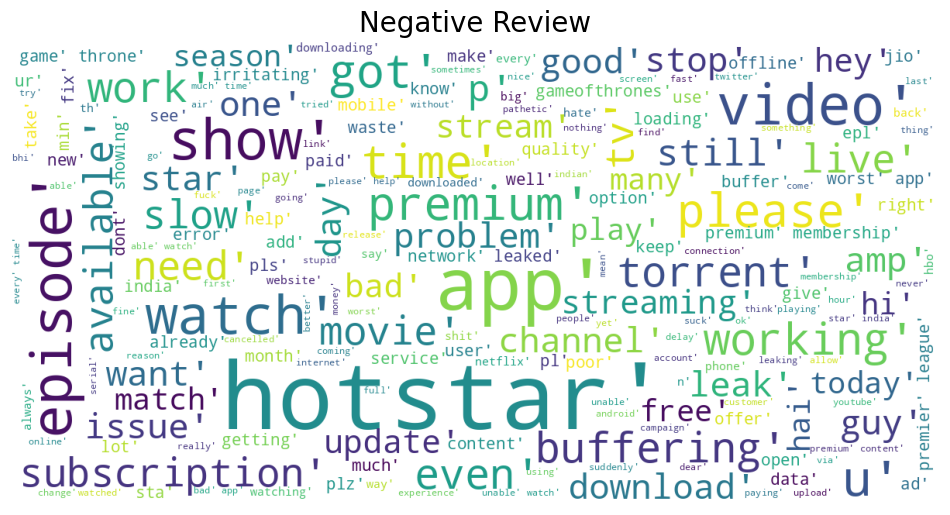

In [217]:
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(12,12))
plt.axis('off')
plt.imshow(wordcloud_neg)
plt.title("Negative Review", size=20)
plt.show()

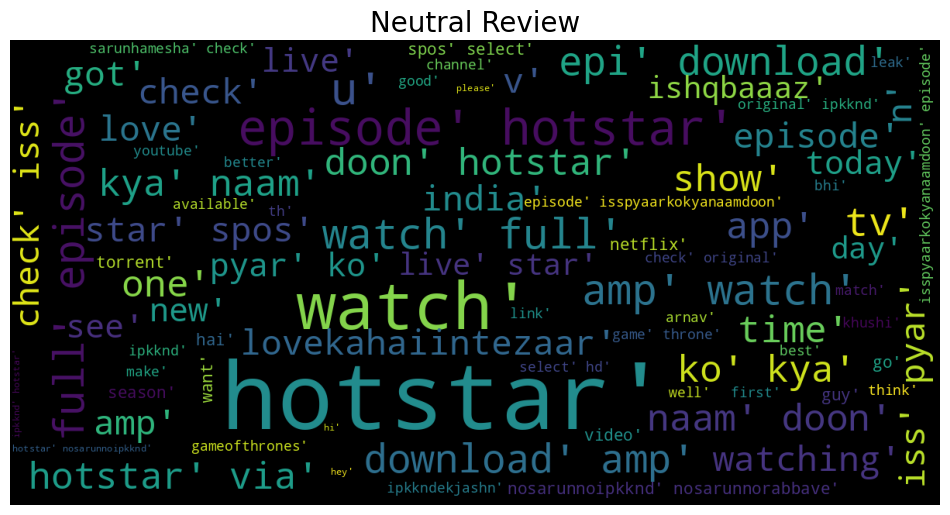

In [218]:
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(12,12))
plt.axis('off')
plt.imshow(wordcloud_neu)
plt.title("Neutral Review", size=20)
plt.show()

# Deep Learning Approach

In [219]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras import Sequential

In [220]:
review_data.head()

,Reviews,Source,Sentiment,clean_review
0,hh,0,Negative,hh
1,no,0,Negative,
2,@hotstar_helps during paymnt for premium subsc...,1,Negative,paymnt premium subscription transaction failed...
3,@hotstartweets i am currently on jio network a...,1,Negative,currently jio network know whether able watch ...
4,@hotstartweets the episodes of sarabhai vs sar...,1,Negative,episode sarabhai v sarabhai season downloadabl...


In [221]:
review_data1 = review_data[['clean_review','Sentiment']]

In [222]:
review_data1.head()

,clean_review,Sentiment
0,hh,Negative
1,,Negative
2,paymnt premium subscription transaction failed...,Negative
3,currently jio network know whether able watch ...,Negative
4,episode sarabhai v sarabhai season downloadabl...,Negative


In [223]:
review_data1['Sentiment'] = review_data1['Sentiment'].astype('category')
review_data1['Sentiment'] = review_data1['Sentiment'].cat.codes
review_data1['Sentiment'].value_counts()

/tmp/ipython-input-2624856155.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data1['Sentiment'] = review_data1['Sentiment'].astype('category')
/tmp/ipython-input-2624856155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data1['Sentiment'] = review_data1['Sentiment'].cat.codes


,count
Sentiment,
1,1738
2,1733
0,1582


In [224]:
review_data1.head()

,clean_review,Sentiment
0,hh,0
1,,0
2,paymnt premium subscription transaction failed...,0
3,currently jio network know whether able watch ...,0
4,episode sarabhai v sarabhai season downloadabl...,0


In [225]:
x = review_data1.iloc[:,0:1]
y = review_data1.iloc[:,-1]

In [226]:
x.head()

,clean_review
0,hh
1,
2,paymnt premium subscription transaction failed...
3,currently jio network know whether able watch ...
4,episode sarabhai v sarabhai season downloadabl...


In [227]:
y.head()

,Sentiment
0,0
1,0
2,0
3,0
4,0


In [228]:
y.value_counts()

,count
Sentiment,
1,1738
2,1733
0,1582


In [231]:
x_vec

NameError: name 'x_vec' is not defined

In [232]:
# split the data into training and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,
                                                y,test_size=0.2,
                                                   random_state=42,
                                                   stratify=y)

In [233]:
x_train

,clean_review
2669,good aap
4312,suddenly stas buffering n buffering n bufferin...
2512,watch bengaluru bull v telugu titan live star ...
2722,osam app
3254,easy use
...,...
350,app working
4952,glad waited watched latest gameofthrones episo...
958,called live feed exact second delayed transmis...
67,order id premium membership cancelled free tra...


In [234]:
x.columns

Index(['clean_review'], dtype='object')

In [235]:
bow = CountVectorizer()
x_bow = bow.fit_transform(x['clean_review']).toarray()

In [236]:
x_bow1=pd.DataFrame(x_bow)
x_bow1.head()

,0,1,2,3,4,5,6,7,8,9,...,5599,5600,5601,5602,5603,5604,5605,5606,5607,5608
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [237]:
x_bow1.shape, y.shape

((5053, 5609), (5053,))

In [250]:
# vectorize the text data using CountVectorizer
vectorizer = CountVectorizer(binary=True)
x_train_vectorized = vectorizer.fit_transform(x_train['clean_review'])
x_test_vectorized = vectorizer.transform(x_test['clean_review'])

KeyError: 'clean_review'

In [246]:
x_train_vectorized

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 1 stored elements and shape (1, 1)>

In [247]:
x_train = pd.DataFrame(x_train_vectorized.toarray())
x_test = pd.DataFrame(x_test_vectorized.toarray())

In [248]:
x_train.shape, x_test.shape, y_train_new2['y_label'].shape, y_test_new2['y_label'].shape

((1, 1), (1, 1), (4042,), (1011,))

In [251]:
# split the data into training and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(review_data1[['clean_review']],
                                                review_data1['Sentiment'],test_size=0.2,
                                                   random_state=42,
                                                   stratify=review_data1['Sentiment'])

In [252]:
# vectorize the text data using CountVectorizer
vectorizer = CountVectorizer(binary=True)
x_train_vectorized = vectorizer.fit_transform(x_train['clean_review'])
x_test_vectorized = vectorizer.transform(x_test['clean_review'])

In [240]:
from sklearn.model_selection import train_test_split

# Split data for deep learning model
x_train_dl, x_test_dl, y_train_dl, y_test_dl = train_test_split(x_bow1, y, test_size=0.2, random_state=42, stratify=y)


model = Sequential()
model.add(Dense(64, activation='relu', input_dim=x_train_dl.shape[1])) # Use the shape of the training data
model.add(Dense(8,activation='relu'))
model.add(Dense(3, activation='softmax')) # Changed activation to linear/removed activation. Changed back to softmax to match loss function
model.compile(optimizer='adam',loss=keras.losses.SparseCategoricalCrossentropy(), # Removed from_logits=True
              metrics=['accuracy'])
model.fit(x_train_dl, y_train_dl, epochs=100, batch_size=32, validation_split=0.2) # Use split data

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4695 - loss: 1.0539 - val_accuracy: 0.6119 - val_loss: 0.8422
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7375 - loss: 0.7098 - val_accuracy: 0.7614 - val_loss: 0.6687
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8876 - loss: 0.4281 - val_accuracy: 0.7577 - val_loss: 0.6150
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9355 - loss: 0.2677 - val_accuracy: 0.7627 - val_loss: 0.6147
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9512 - loss: 0.1825 - val_accuracy: 0.7614 - val_loss: 0.6597
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9618 - loss: 0.1374 - val_accuracy: 0.7565 - val_loss: 0.6907
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9649 - loss: 0.1132 - val_accuracy: 0.7602 - val_loss: 0.7116
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9716 - loss: 0.0909 - val_

In [267]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras import Sequential, regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import numpy as np # Import numpy

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9, sublinear_tf=True)
X_tfidf = tfidf.fit_transform(x_train['clean_review']) # Corrected variable name to x_train
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_svd = svd.fit_transform(X_tfidf)
X_val_svd = svd.transform(tfidf.transform(x_test['clean_review']))  # Corrected variable name to x_test

model = Sequential([
    keras.Input(shape=(300,)),
    Dense(128, kernel_regularizer=regularizers.l2(1e-3)),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.5),
    Dense(64, kernel_regularizer=regularizers.l2(1e-3)),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation="softmax") # Use np.unique to get the number of classes
])


loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1.0)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)


history = model.fit(X_train_svd, y_train, validation_data=(X_val_svd, y_test),
          epochs=50, batch_size=64, callbacks=[es, rlr])


test_loss, test_acc = model.evaluate(X_val_svd, y_test) # Removed .values
print(f"\nFinal Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3413 - loss: 1.6403 - val_accuracy: 0.4135 - val_loss: 1.3497 - learning_rate: 3.0000e-04
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4455 - loss: 1.3879 - val_accuracy: 0.4461 - val_loss: 1.3311 - learning_rate: 3.0000e-04
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5045 - loss: 1.2638 - val_accuracy: 0.5173 - val_loss: 1.3007 - learning_rate: 3.0000e-04
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5779 - loss: 1.1519 - val_accuracy: 0.5945 - val_loss: 1.2569 - learning_rate: 3.0000e-04
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6041 - loss: 1.0983 - val_accuracy: 0.6350 - val_loss: 1.2000 - learning_rate: 3.0000e-04
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6575 - loss: 1.0420 - val_accuracy: 0.6884 - val_loss: 1.1329 - learning_rate: 3.0000e-04
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6410 - loss

In [269]:
# Install gradio
!pip install gradio

In [270]:
import gradio as gr
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Make sure you have downloaded these resources
# nltk.download('stopwords', quiet=True)
# nltk.download('wordnet', quiet=True)

# Load the trained TF-IDF vectorizer, SVD, and the Deep Learning model
# Assuming 'tfidf', 'svd', and 'model' are already trained in previous cells
tfidf_vectorizer = tfidf # Use the trained TF-IDF vectorizer
svd_reducer = svd # Use the trained SVD
deep_learning_model = model # Use the trained deep learning model

# Define the preprocessing steps (same as before)
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
wd = WordNetLemmatizer()

def preprocess_text(text):
    re_pattern = """@[a-zA-Z0-9_:]+|b['"]rt|[\d]+[a-zA-Z_+='?]+[\d]+[\d]+|[a-zA-Z_*+=]+[\d]+[a-zA-Z_*+-=]+|[\d]+"""
    re_pattern = re_pattern + """|https:+[a-zA-Z0-9/._+-=]+|&amp;|rt"""
    review = re.sub(pattern=re_pattern, string=text, repl="")
    stop_free = " ".join([txt for txt in review.lower().split() if txt not in stop_words])
    puct_free = " ".join([txt for txt in stop_free.lower().split() if txt not in punctuation])
    final_words = puct_free.replace("#", '')
    clean_review = " ".join(wd.lemmatize(word) for word in final_words.split())
    return clean_review

# Define the prediction function for the deep learning model
def predict_sentiment_dl(review):
    cleaned_review = preprocess_text(review)
    # Vectorize the cleaned review using the fitted TF-IDF vectorizer
    tfidf_vector = tfidf_vectorizer.transform([cleaned_review])
    # Reduce dimensionality using the fitted SVD
    svd_vector = svd_reducer.transform(tfidf_vector)
    # Predict the sentiment using the deep learning model
    prediction = deep_learning_model.predict(svd_vector)[0]

    # Map the numerical prediction back to sentiment labels
    # The output of the deep learning model is probabilities for each class
    # We need to find the class with the highest probability
    predicted_class = tf.argmax(prediction).numpy()

    # Assuming the original mapping was 0: Negative, 1: Neutral, 2: Positive
    # Check the value_counts of review_data1['Sentiment'] to confirm the mapping
    # review_data1['Sentiment'].value_counts() gives 1: 1738 (Neutral), 2: 1733 (Positive), 0: 1582 (Negative)
    # So the mapping is 0: Negative, 1: Neutral, 2: Positive
    sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    predicted_sentiment = sentiment_map.get(predicted_class, 'Unknown')

    return predicted_sentiment

# Create the Gradio interface
interface_dl = gr.Interface(
    fn=predict_sentiment_dl,
    inputs=gr.Textbox(lines=5, label="Enter Review"),
    outputs=gr.Textbox(label="Predicted Sentiment"),
    title="Hotstar Review Sentiment Analysis (Deep Learning Model)",
    description="Enter a review to get its predicted sentiment (Positive, Negative, or Neutral)."
)

# Launch the interface
interface_dl.launch()

<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2494136117.py:28: SyntaxWarning: invalid escape sequence '\d'
  re_pattern = """@[a-zA-Z0-9_:]+|b['"]rt|[\d]+[a-zA-Z_+='?]+[\d]+[\d]+|[a-zA-Z_*+=]+[\d]+[a-zA-Z_*+-=]+|[\d]+"""


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a192ec9730d03e776e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [271]:
import joblib

# Save the trained deep learning model
model.save('deep_learning_model.h5')

# Save the fitted TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

# Save the fitted SVD reducer
joblib.dump(svd_reducer, 'svd_reducer.pkl')

print("Model, vectorizer, and SVD reducer saved successfully.")

Model, vectorizer, and SVD reducer saved successfully.


Here's the content for your `app.py` file. This script will load the saved model and components and run the Gradio interface.

Here's the content for your `requirements.txt` file. This file lists the Python packages your project depends on.

**To deploy on Hugging Face Spaces:**

1.  Go to [huggingface.co/spaces](https://huggingface.co/spaces) and create a new Space.
2.  Choose a Space name and select "Gradio" as the SDK.
3.  Upload the following files to your Space:
    *   `app.py` (with the content provided above)
    *   `requirements.txt` (with the content provided above)
    *   `deep_learning_model.h5` (the saved model file)
    *   `tfidf_vectorizer.pkl` (the saved vectorizer file)
    *   `svd_reducer.pkl` (the saved SVD reducer file)
4.  Hugging Face Spaces will automatically build and deploy your Gradio application.

Here's the content for your `app.py` file. This script will load the saved model and components and run the Gradio interface.

Here's the content for your `requirements.txt` file. This file lists the Python packages your project depends on.